In [3]:
%run ../setup.py

In [5]:
t, y = np.loadtxt('../data/9651065_lc.txt', usecols=(0,1)).T

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c25f08978>,
      dtype=object)

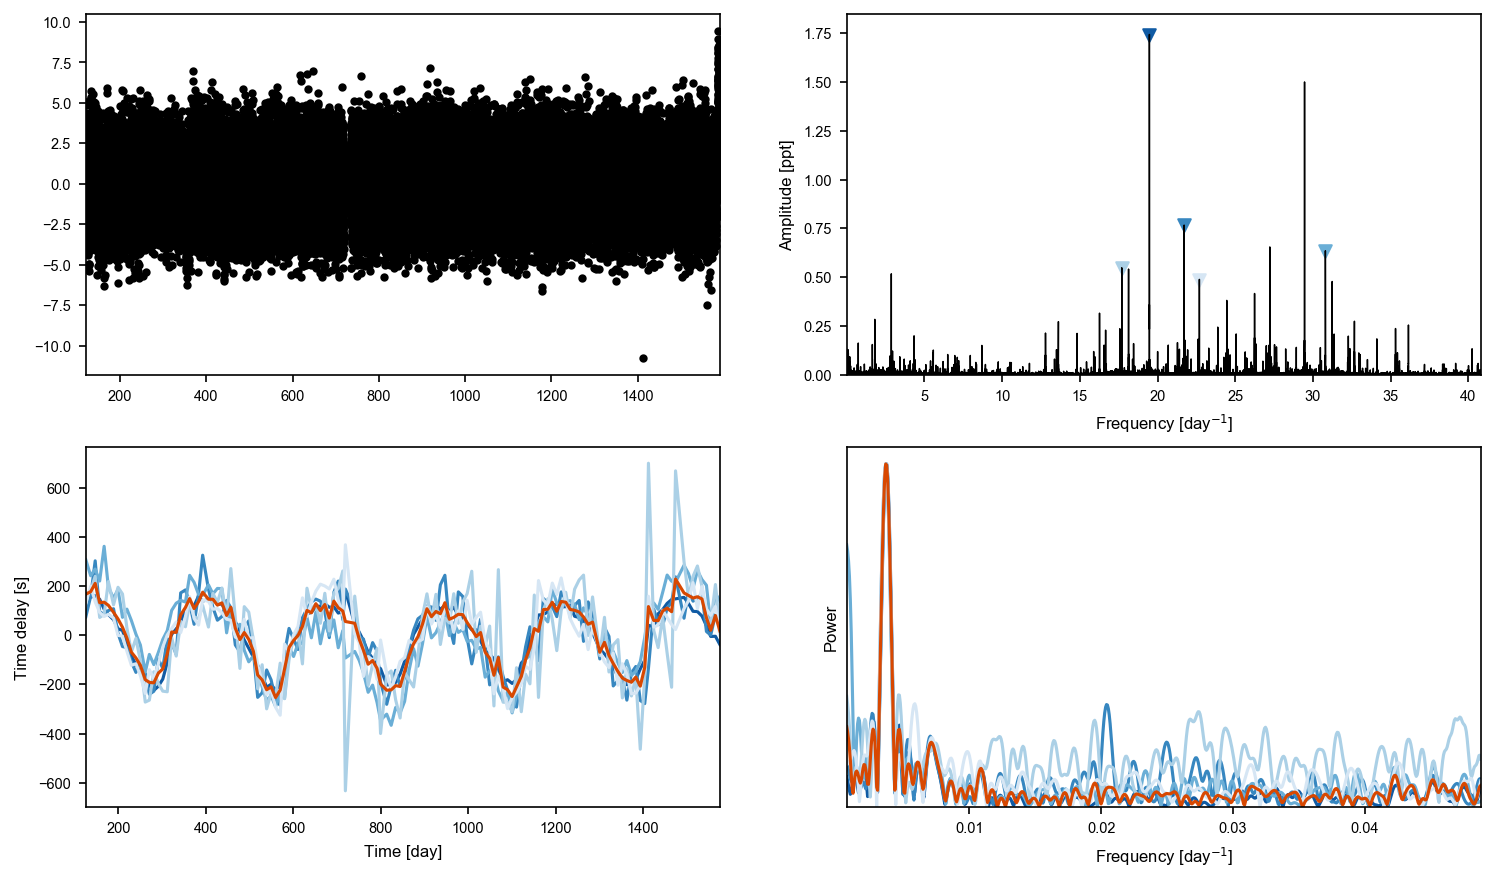

In [7]:
ms = Maelstrom(t, y, max_peaks=5, fmin=5, fmax=48)
ms.first_look()

In [7]:
period_guess = 300
a_guess = 200

time, flux = ms.time, ms.flux
freq = ms.freq
weights = ms.get_weights(norm=False)

In [6]:
pg = ms.period_search()

In [7]:
periods = np.linspace(100, 300, 300)
results = pg.fit(periods)

100%|██████████| 300/300 [10:05<00:00,  1.83s/it]


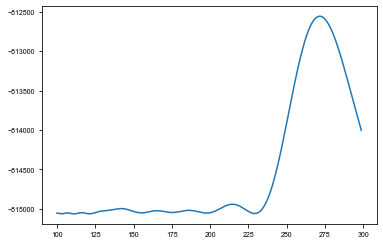

In [8]:
ys = np.array([[r[0] for r in row] for row in results])
sm = np.sum(ys, axis=0)
period_ind = np.argmax(sm)
plt.plot(periods[:-2], sm[:-2]);

In [19]:
from maelstrom.utils import unique_colors

hh = unique_colors(len(ms.freq), cmap='Blues')

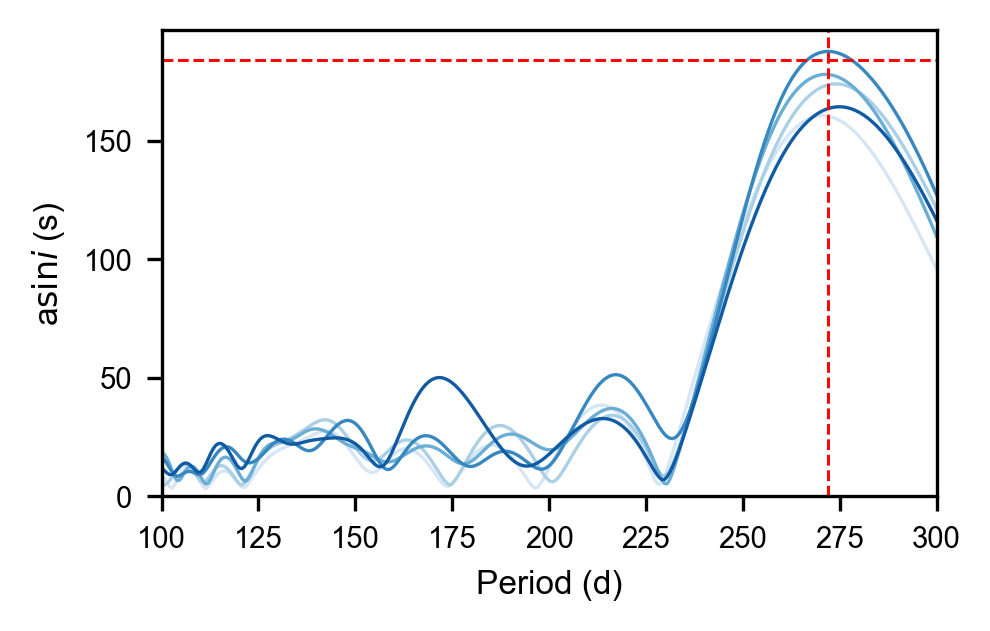

In [28]:
plt.figure(figsize=mnras_size(240.))

ys = np.array([[np.exp(r[1]["logasini"]) for r in row] for row in results])
for i, c in zip(ys, hh):
    plt.plot(periods, i, alpha=1, linewidth=0.8, c=c);

plt.xlabel('Period (d)')
plt.ylabel(r'a$\sin{i}$ (s)')
plt.ylim(0, None)
plt.xlim(100,300)
plt.axhline(184., c='r', linestyle='dashed', linewidth=0.7)
plt.axvline(272., c='r', linestyle='dashed', linewidth=0.7)

plt.savefig(overleaf_path + '9651065_period_search.pdf', dpi=300, bbox_inches='tight', pad_inches=0)

# MAP UNCERTAINTY

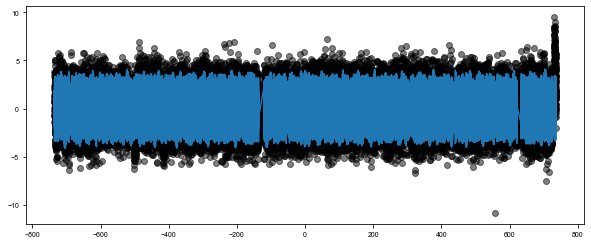

In [6]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt

with pm.Model() as model:
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=1.0, testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Normal('logasini', mu=np.log(a_guess), sd=100, testval=np.log(a_guess))
    asini = pm.Deterministic("asini", tt.exp(logasini))
        
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.5)
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    boosting = pm.Normal('boosting', mu=0., sd=10, testval=0.)
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    arg = ((factor)[None, :] * time[:, None] - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(freq))
    log_min_amp = np.log(0.1 * np.std(flux))  # np.log(np.median(np.abs(np.diff(mag))))
    log_max_amp = np.log(np.std(flux))
    #log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    log_mean_amp = np.log(weights)
    logamp = pm.Bound(pm.Normal,
                      lower=log_min_amp,
                      upper=log_max_amp)("logamp", mu=log_mean_amp, sd=1.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
    
    full_lc = lc_model + mean + boosting*tt.sin(M)
    
    pm.Normal('obs', mu=full_lc, sd=tt.exp(logs_lc), observed=flux)
    
fig, axes = plt.subplots(1,1, figsize=[10,4])
with model:
    
    ax = axes
    ax.plot(time, xo.eval_in_model(lc_model))
    plt.scatter(time,flux, c='black', alpha=0.5)

[logP, phi_angle__, logs_lc, logasini, omega_angle__, eccen_interval__, mean, boosting, lognu, phase_angle__, logamp_interval__]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -308847.67857364065 -> -308847.21862312884
optimizing logp for variables: ['logs_lc']
message: Desired error not necessarily achieved due to precision loss.
logp: -308847.21862312884 -> -158926.4768452319
optimizing logp for variables: ['logamp_interval__', 'phase_angle__']
message: Optimization terminated successfully.
logp: -158926.4768452319 -> -131923.58247861904
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Optimization terminated successfully.
logp: -131923.58247861904 -> -131805.9944743275
optimizing logp for variables: ['phi_angle__']
message: Desired error not necessarily achieved due to precision loss.
logp: -131805.9944743275 -> -131747.93208205642
optimizing logp for variables: ['lognu']
message: Desired error not necessaril

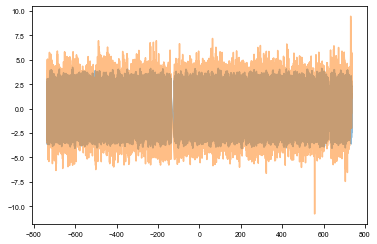

In [7]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, flux, alpha=0.5)

In [8]:
map_params

{'logP': array(5.60679164),
 'phi_angle__': array([-1.72375928,  4.12657458]),
 'logs_lc': array(0.11244486),
 'logasini': array(5.22128068),
 'omega_angle__': array([-3.78698607,  2.37880833]),
 'eccen_interval__': array(-0.01454628),
 'mean': array(0.00059576),
 'boosting': array(0.00578857),
 'lognu': array([2.96926915, 3.07787135, 3.42757632, 2.87353169, 3.12211358]),
 'phase_angle__': array([[ 3.39486695,  4.2183438 , -0.46448715,  2.4070093 , -0.07211062],
        [-2.91116873, -1.48511557,  4.44794853,  3.76912419,  4.47155038]]),
 'logamp_interval__': array([ 3.40703271,  0.46680119,  0.16190385, -0.13700614, -0.32680067]),
 'period': array(272.26929714),
 'phi': array(-0.39568965),
 'asini': array(185.17117754),
 'omega': array(-1.00993258),
 'eccen': array(0.44672714),
 'nu': array([19.47767904, 21.71213556, 30.8018983 , 17.69941683, 22.69429519]),
 'phase': array([ 2.27964038,  1.90930631, -0.10405015,  0.56832815, -0.01612514]),
 'logamp': array([ 0.56860491, -0.24489205, -

In [7]:
# Maelstrom model

In [8]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt
import theano

time_tensor = theano.shared(time)
flux_tensor = theano.shared(flux)

mag = flux

with pm.Model() as new_model:
    # Period
    logP = pm.Normal("logP", mu=np.log(272.), sd=0.1, shape=1)
    period = pm.Deterministic("period", pm.math.exp(logP))
    #period = 6.1281610
    drift = pm.Normal('drift_grad', mu=0.0, sd=0.01)
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(mag)), sd=10, testval=0.)
    logasini = pm.Uniform("logasini", lower=np.log(1), upper=np.log(1000),
                          testval=np.log(100)) 
    asini = pm.Deterministic("asini", tt.exp(logasini))
    
    omega = xo.distributions.Angle("omega")
    eccen = pm.Uniform('eccen', lower=1e-4, upper=0.99, testval=1e-3)
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.00)
   
    # Mean anom
    M = 2.0 * np.pi * time_tensor / period - phi
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + tt.zeros_like(M))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    factor = 2. * np.pi * freq
    arg = (factor * (1 - drift)) * time_tensor[:, None]
    arg -= (factor * (tt.exp(logasini)) / 86400) * psi[:, None]
    
    sinarg = tt.sin(arg)
    cosarg = tt.cos(arg)
    DT = tt.concatenate((sinarg, cosarg), axis=-1).T
    D = DT.T
    # Singular matrix ?
    #DT = tt.concatenate((sinarg, cosarg, tt.ones_like(sinarg)), axis=-1).T
    #D = DT.T
    w = tt.slinalg.solve(tt.dot(DT, D), tt.dot(DT, flux_tensor))
    pm.Deterministic('w', w)
    pm.Deterministic("phase", tt.arctan2(w[1], w[0]))
    lc_model = tt.dot(D, w)
    
    # Jitter & GP parameters
    BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=1000)
    
    logw0 = BoundedNormal("logw0", mu=np.log(2*np.pi/10), sd=1)
    logpower = BoundedNormal("logpower", mu=np.log(np.var(mag)), sd=1)
    
    #logw0 = pm.Normal("logw0", mu=np.log(2*np.pi/10), sd=10)
    #logpower = pm.Normal("logpower", mu=np.log(np.var(mag)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean
    
    pm.Potential("obs", gp.log_likelihood(mag - full_lc))
    #pm.Deterministic("gp_pred", gp.predict())
    
    trace = pm.load_trace('traces/9651065_FINAL_VERSION2/')

In [ ]:
with new_model:
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc, logw0, logpower])
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, mag, alpha=0.5)

optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -351577.8313600357 -> -351577.8240820869
optimizing logp for variables: ['logpower_interval__', 'logw0_interval__', 'logs_lc']
message: Desired error not necessarily achieved due to precision loss.
logp: -351577.8240820869 -> -97751.0197216691
optimizing logp for variables: ['logasini_interval__']
message: Optimization terminated successfully.
logp: -97751.0197216691 -> -97663.17955289801
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']


In [ ]:
map_params

In [50]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with new_model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 2 chains: 100%|██████████| 1004/1004 [08:27<00:00,  1.69draws/s]


In [52]:
with new_model:
    trace = sampler.sample(draws=2000)

Sampling 2 chains: 100%|██████████| 4000/4000 [21:53<00:00,  1.95draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logP__0,5.606920e+00,1.425711e-03,1.943586e-05,5.604017e+00,5.609626e+00,4446.423611,0.999858
drift_grad,-1.275846e-07,4.863209e-08,7.129154e-10,-2.217261e-07,-2.831711e-08,5444.460063,0.999755
logs_lc,4.291762e-02,2.782642e-03,3.234321e-05,3.724385e-02,4.833112e-02,5971.432014,0.999992
mean,2.628055e-03,1.579733e-02,2.168958e-04,-2.849035e-02,3.343055e-02,5448.501859,0.999887
period__0,2.723045e+02,3.882409e-01,5.293490e-03,2.715148e+02,2.730420e+02,4445.960267,0.999857
phi,-3.786381e-01,5.888085e-02,1.022046e-03,-4.932405e-01,-2.671699e-01,3190.204115,0.999754
logasini,5.221114e+00,1.793113e-02,2.349851e-04,5.185097e+00,5.255951e+00,5051.194602,0.999831
asini,1.851701e+02,3.321538e+00,4.351047e-02,1.782303e+02,1.913227e+02,5041.266956,0.999834
omega,-9.920623e-01,6.511631e-02,1.103858e-03,-1.122696e+00,-8.747689e-01,3146.923286,0.999785
eccen,4.452958e-01,2.841854e-02,4.222633e-04,3.923645e-01,5.028835e-01,4937.417574,0.999831


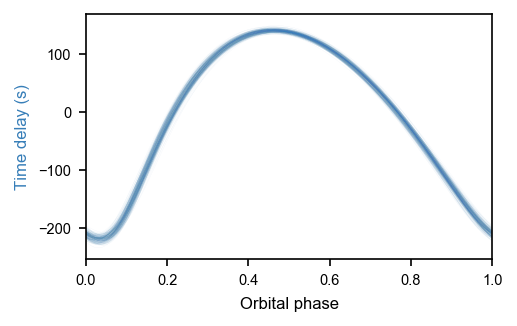

In [78]:

fig, ax = plt.subplots(figsize=mnras_size(240), constrained_layout=True)

ax.set_rasterized(True)
#ax.set_rasterization_zorder(1)

with new_model:
    for samp in xo.utils.get_samples_from_trace(trace, size=300):
        taumod = xo.eval_in_model(asini * psi, samp)
        #ttime = (ms.time_mid + time - samp['tref']) % samp['period'] / samp['period']
        ttime = (ms.time_mid + time) % samp['period'] / samp['period']
        #ttime = ((ms.time_mid + time) + (samp['phi'] * samp['period'] / (2*np.pi))) % samp['period'] / samp['period']
        sort = np.argsort(ttime)
        ax.plot(ttime[sort], (taumod - np.mean(taumod))[sort], color=blue, linewidth=0.1, alpha=0.1, 
#                 rasterized=True,
                zorder=1)
        
    

#a, b = ms.get_time_delay(segment_size=10)
#bb = np.average(b, axis=1, weights=ms.get_weights())
#plt.plot((a + ms.time_mid) % np.median(trace['period']) / np.median(trace['period']) ,bb, '.k', markersize=2)

ax.set_xlabel('Orbital phase')
ax.set_ylabel('Time delay (s)', c=blue)

ax.set_xlim(0, 1)

plt.savefig(overleaf_path + '9651065.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
#plt.savefig('rast.pdf', dpi=300, bbox_inches='tight')

In [10]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
mfs = mass_function(samples['period__0'].values * u.day, samples['asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.092  +  0.005  -  0.005


In [11]:
varnames=['period', 'phi', 'eccen', 'asini', 'omega', 'logw0', 'logS0']
rounding = 2
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  272.29  +  0.4  -  0.37
phi :  -0.38  +  0.06  -  0.06
eccen :  0.45  +  0.03  -  0.03
asini :  185.14  +  3.32  -  3.21
omega :  -0.99  +  0.07  -  0.07
logw0 :  0.44  +  0.02  -  0.02
logS0 :  -1.77  +  0.07  -  0.06


# DFM model

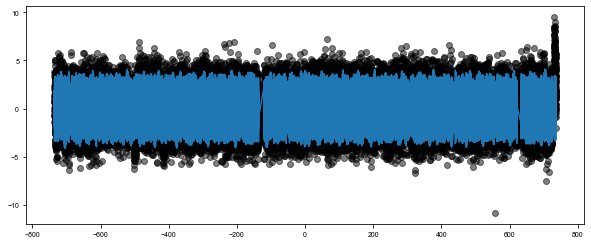

In [40]:
from exoplanet.orbits import get_true_anomaly
import exoplanet as xo
import astropy.units as u
import theano.tensor as tt

with pm.Model() as model:
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=1.0, testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Normal('logasini', mu=np.log(a_guess), sd=100, testval=np.log(a_guess))
    asini = pm.Deterministic("asini", tt.exp(logasini))
        
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.5)
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    boosting = pm.Normal("boosting", mu=0., sd=10., testval=0.)
    # Mean anom
    M = 2.0 * np.pi * time / period - phi
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    
    lognu = pm.Normal("lognu", mu=np.log(freq), sd=0.1, shape=len(freq))
    nu = pm.Deterministic("nu", tt.exp(lognu))
    factor = 2. * np.pi * nu
    arg = ((factor)[None, :] * time[:, None] - (factor * asini / 86400)[None, :] * psi[:, None])

    phase = xo.distributions.Angle("phase", shape=len(freq))
    log_min_amp = np.log(0.1 * np.std(flux))  # np.log(np.median(np.abs(np.diff(mag))))
    log_max_amp = np.log(np.std(flux))
    #log_mean_amp = 0.5*(log_min_amp + log_max_amp)
    log_mean_amp = np.log(weights)
    logamp = pm.Bound(pm.Normal,
                      lower=log_min_amp,
                      upper=log_max_amp)("logamp", mu=log_mean_amp, sd=1.0, shape=len(freq),
                                         testval=log_mean_amp)
    lc_model = tt.sum(tt.exp(logamp)[None, :] * tt.sin(arg - phase[None, :]), axis=1)
        
    # GP parameters
    logw0 = pm.Bound(pm.Normal,
                     lower=np.log(2*np.pi/100.0),
                     upper=np.log(2*np.pi/2.0))("logw0", mu=np.log(2*np.pi/10), sd=10,
                                                testval=np.log(2*np.pi/10))
    logpower = pm.Normal("logpower", mu=np.log(np.var(flux)), sd=10)
    logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)
    kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
    gp = xo.gp.GP(kernel, time, tt.exp(2*logs_lc) + tt.zeros(len(time)), J=2)
    
    full_lc = lc_model + mean + boosting * tt.sin(M)
    pm.Potential("obs", gp.log_likelihood(flux - full_lc))
    
fig, axes = plt.subplots(1,1, figsize=[10,4])
with model:
    
    ax = axes
    ax.plot(time, xo.eval_in_model(lc_model))
    plt.scatter(time,flux, c='black', alpha=0.5)

In [41]:
profile_model(model)

-306129.5006071612
28.1 ms ± 706 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


[logP, phi_angle__, logs_lc, logasini, omega_angle__, eccen_interval__, mean, boosting, lognu, phase_angle__, logamp_interval__, logw0_interval__, logpower]
optimizing logp for variables: ['mean']
message: Optimization terminated successfully.
logp: -306129.500594695 -> -306129.5005945943
optimizing logp for variables: ['logs_lc']
message: Desired error not necessarily achieved due to precision loss.
logp: -306129.5005945943 -> -160093.83166952222
optimizing logp for variables: ['logw0_interval__', 'logpower']
message: Desired error not necessarily achieved due to precision loss.
logp: -160093.83166952222 -> -158712.5635731562
optimizing logp for variables: ['logamp_interval__', 'phase_angle__']
message: Optimization terminated successfully.
logp: -158712.5635731562 -> -131574.51140317027
optimizing logp for variables: ['omega_angle__', 'eccen_interval__']
message: Optimization terminated successfully.
logp: -131574.51140317027 -> -131456.27863536257
optimizing logp for variables: ['ph

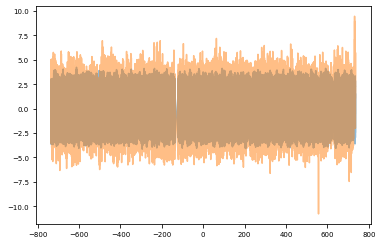

In [7]:
with model:
    all_but = [v for v in model.vars if v.name not in ["logP_interval__", "logasini_interval__"]]
    print(all_but)
    
    map_params = xo.optimize(start=None, vars=[mean])
    map_params = xo.optimize(start=map_params, vars=[logs_lc])
    map_params = xo.optimize(start=map_params, vars=[logpower, logw0])
    map_params = xo.optimize(start=map_params, vars=[phase, logamp])
    map_params = xo.optimize(start=map_params, vars=[eccen, omega])
    map_params = xo.optimize(start=map_params, vars=[phi])
    map_params = xo.optimize(start=map_params, vars=[lognu])
    map_params = xo.optimize(start=map_params, vars=all_but)
    
    map_params = xo.optimize(start=map_params, vars=[logasini])
    map_params = xo.optimize(start=map_params, vars=all_but)

    map_params = xo.optimize(start=map_params, vars=[logP])
    map_params = xo.optimize(start=map_params, vars=all_but)

    plt.plot(time, xo.eval_in_model(lc_model, map_params), alpha=0.5)
    plt.plot(time, flux, alpha=0.5)

In [9]:
map_params

{'logP': array(5.60693031),
 'phi_angle__': array([-1.63984483,  4.16058799]),
 'logs_lc': array(0.04325372),
 'logasini': array(5.22188358),
 'omega_angle__': array([-3.73503413,  2.45949948]),
 'eccen_interval__': array(-0.01295933),
 'mean': array(0.01221354),
 'boosting': array(-0.01204979),
 'lognu': array([2.96926914, 3.07787135, 3.42757631, 2.87353169, 3.12211357]),
 'phase_angle__': array([[ 3.38956927,  4.2162745 , -0.45298224,  2.41496249, -0.06078257],
        [-2.91751829, -1.49113258,  4.44917295,  3.76405939,  4.47172306]]),
 'logamp_interval__': array([ 3.40705708,  0.46713128,  0.16292311, -0.13803105, -0.32609936]),
 'logw0_interval__': array(0.24616409),
 'logpower': array(-3.0277684),
 'period': array(272.30705635),
 'phi': array(-0.37544253),
 'asini': array(185.28284982),
 'omega': array(-0.98847273),
 'eccen': array(0.44708419),
 'nu': array([19.47767893, 21.71213574, 30.80189803, 17.69941689, 22.69429504]),
 'phase': array([ 2.28148925,  1.91072904, -0.10146307, 

In [ ]:
sampler = xo.PyMC3Sampler(window=200, finish=500)
with model:
    burnin = sampler.tune(tune=1000, step_kwargs=dict(target_accept=0.9), start=map_params)

Sampling 4 chains:  60%|█████▉    | 1744/2908 [12:54<06:45,  2.87draws/s]

In [21]:
with model:
    trace = sampler.sample(draws=1000)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logpower, logw0, logamp, phase, lognu, mean, eccen, omega, logasini, logs_lc, phi, logP]
Sampling 2 chains: 100%|██████████| 2000/2000 [14:25<00:00,  2.22draws/s]


In [22]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logP,5.606935,1.455171e-03,2.357832e-05,5.604220,5.609866,4091.469425,0.999521
logs_lc,0.043440,2.911789e-03,4.081594e-05,0.037475,0.049095,6147.357943,0.999501
logasini,5.221483,1.881522e-02,3.927483e-04,5.184861,5.256568,2911.774883,0.999547
mean,0.013216,2.686770e-02,3.764529e-04,-0.038528,0.065928,4646.295234,0.999502
lognu__0,2.969269,6.509594e-08,9.686273e-10,2.969269,2.969269,5160.519116,0.999713
lognu__1,3.077871,1.320127e-07,2.174085e-09,3.077871,3.077872,3652.595458,1.000236
lognu__2,3.427576,1.065142e-07,1.753995e-09,3.427576,3.427577,4434.063600,0.999800
lognu__3,2.873532,2.195352e-07,3.412605e-09,2.873531,2.873532,4067.270551,0.999634
lognu__4,3.122114,1.894470e-07,2.885338e-09,3.122113,3.122114,5141.247309,0.999673
logpower,-3.030173,1.011850e-01,1.450748e-03,-3.228666,-2.829699,5537.624795,0.999838


In [25]:
pm.save_trace(trace,'traces/9651065_FINAL_VERSION')

'traces/9651065_FINAL_VERSION'

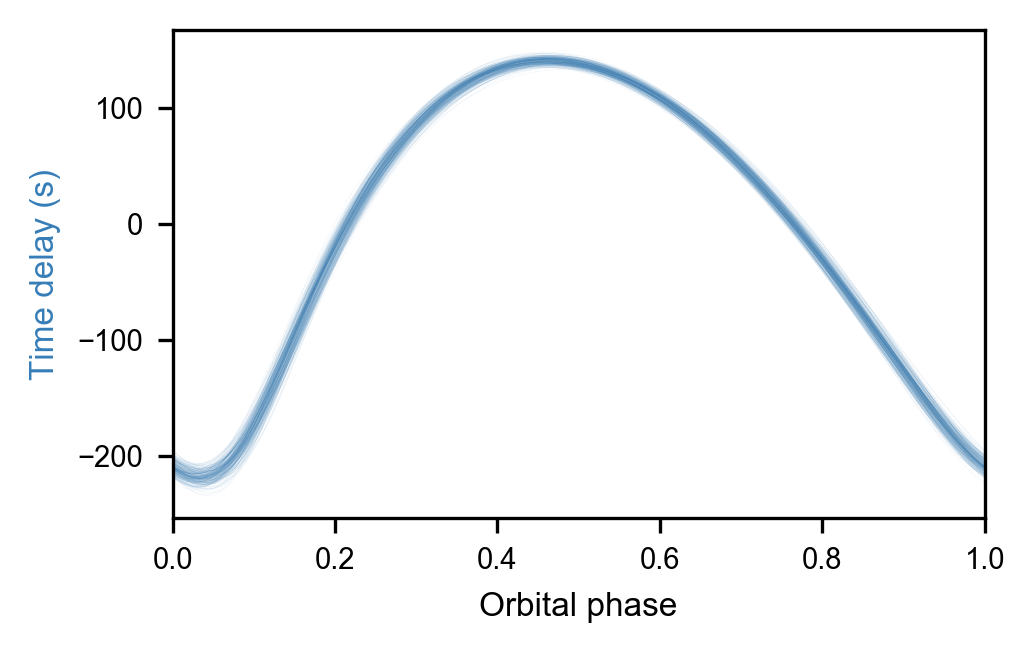

In [144]:

fig, ax = plt.subplots(figsize=mnras_size(240), constrained_layout=True)

with model:
    for samp in xo.utils.get_samples_from_trace(trace, size=300):
        taumod = xo.eval_in_model(asini * psi, samp)
        #ttime = (ms.time_mid + time - samp['tref']) % samp['period'] / samp['period']
        ttime = (ms.time_mid + time) % samp['period'] / samp['period']
        #ttime = ((ms.time_mid + time) + (samp['phi'] * samp['period'] / (2*np.pi))) % samp['period'] / samp['period']
        sort = np.argsort(ttime)
        ax.plot(ttime[sort], (taumod - np.mean(taumod))[sort], color=blue, linewidth=0.1, alpha=0.1, rasterized=True)
        
    

#a, b = ms.get_time_delay(segment_size=10)
#bb = np.average(b, axis=1, weights=ms.get_weights())
#plt.plot((a + ms.time_mid) % np.median(trace['period']) / np.median(trace['period']) ,bb, '.k', markersize=2)

ax.set_xlabel('Orbital phase')
ax.set_ylabel('Time delay (s)', c=blue)

ax.set_xlim(0, 1)

plt.savefig(overleaf_path + '9651065.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [128]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
mfs = mass_function(samples['period'].values * u.day, samples['asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.092  +  0.005  -  0.005


In [127]:
mfs.unit.to_string('latex')

'$\\mathrm{M_{\\odot}}$'

In [92]:
varnames=['period', 'phi', 'eccen', 'asini', 'omega', 'logw0', 'logS0']
rounding = 2
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  272.3  +  0.41  -  0.39
phi :  -0.37  +  0.06  -  0.06
eccen :  0.45  +  0.03  -  0.03
asini :  185.14  +  3.66  -  3.44
omega :  -0.99  +  0.06  -  0.07
logw0 :  -0.57  +  0.04  -  0.04
logS0 :  -0.73  +  0.11  -  0.11


In [58]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logP,5.606935,1.455171e-03,2.357832e-05,5.604220,5.609866,4091.469425,0.999521
logs_lc,0.043440,2.911789e-03,4.081594e-05,0.037475,0.049095,6147.357943,0.999501
logasini,5.221483,1.881522e-02,3.927483e-04,5.184861,5.256568,2911.774883,0.999547
mean,0.013216,2.686770e-02,3.764529e-04,-0.038528,0.065928,4646.295234,0.999502
lognu__0,2.969269,6.509594e-08,9.686273e-10,2.969269,2.969269,5160.519116,0.999713
lognu__1,3.077871,1.320127e-07,2.174085e-09,3.077871,3.077872,3652.595458,1.000236
lognu__2,3.427576,1.065142e-07,1.753995e-09,3.427576,3.427577,4434.063600,0.999800
lognu__3,2.873532,2.195352e-07,3.412605e-09,2.873531,2.873532,4067.270551,0.999634
lognu__4,3.122114,1.894470e-07,2.885338e-09,3.122113,3.122114,5141.247309,0.999673
logpower,-3.030173,1.011850e-01,1.450748e-03,-3.228666,-2.829699,5537.624795,0.999838


In [54]:
ax.collections

[]

In [50]:
np.shape(all_times
        )

(300, 65266)

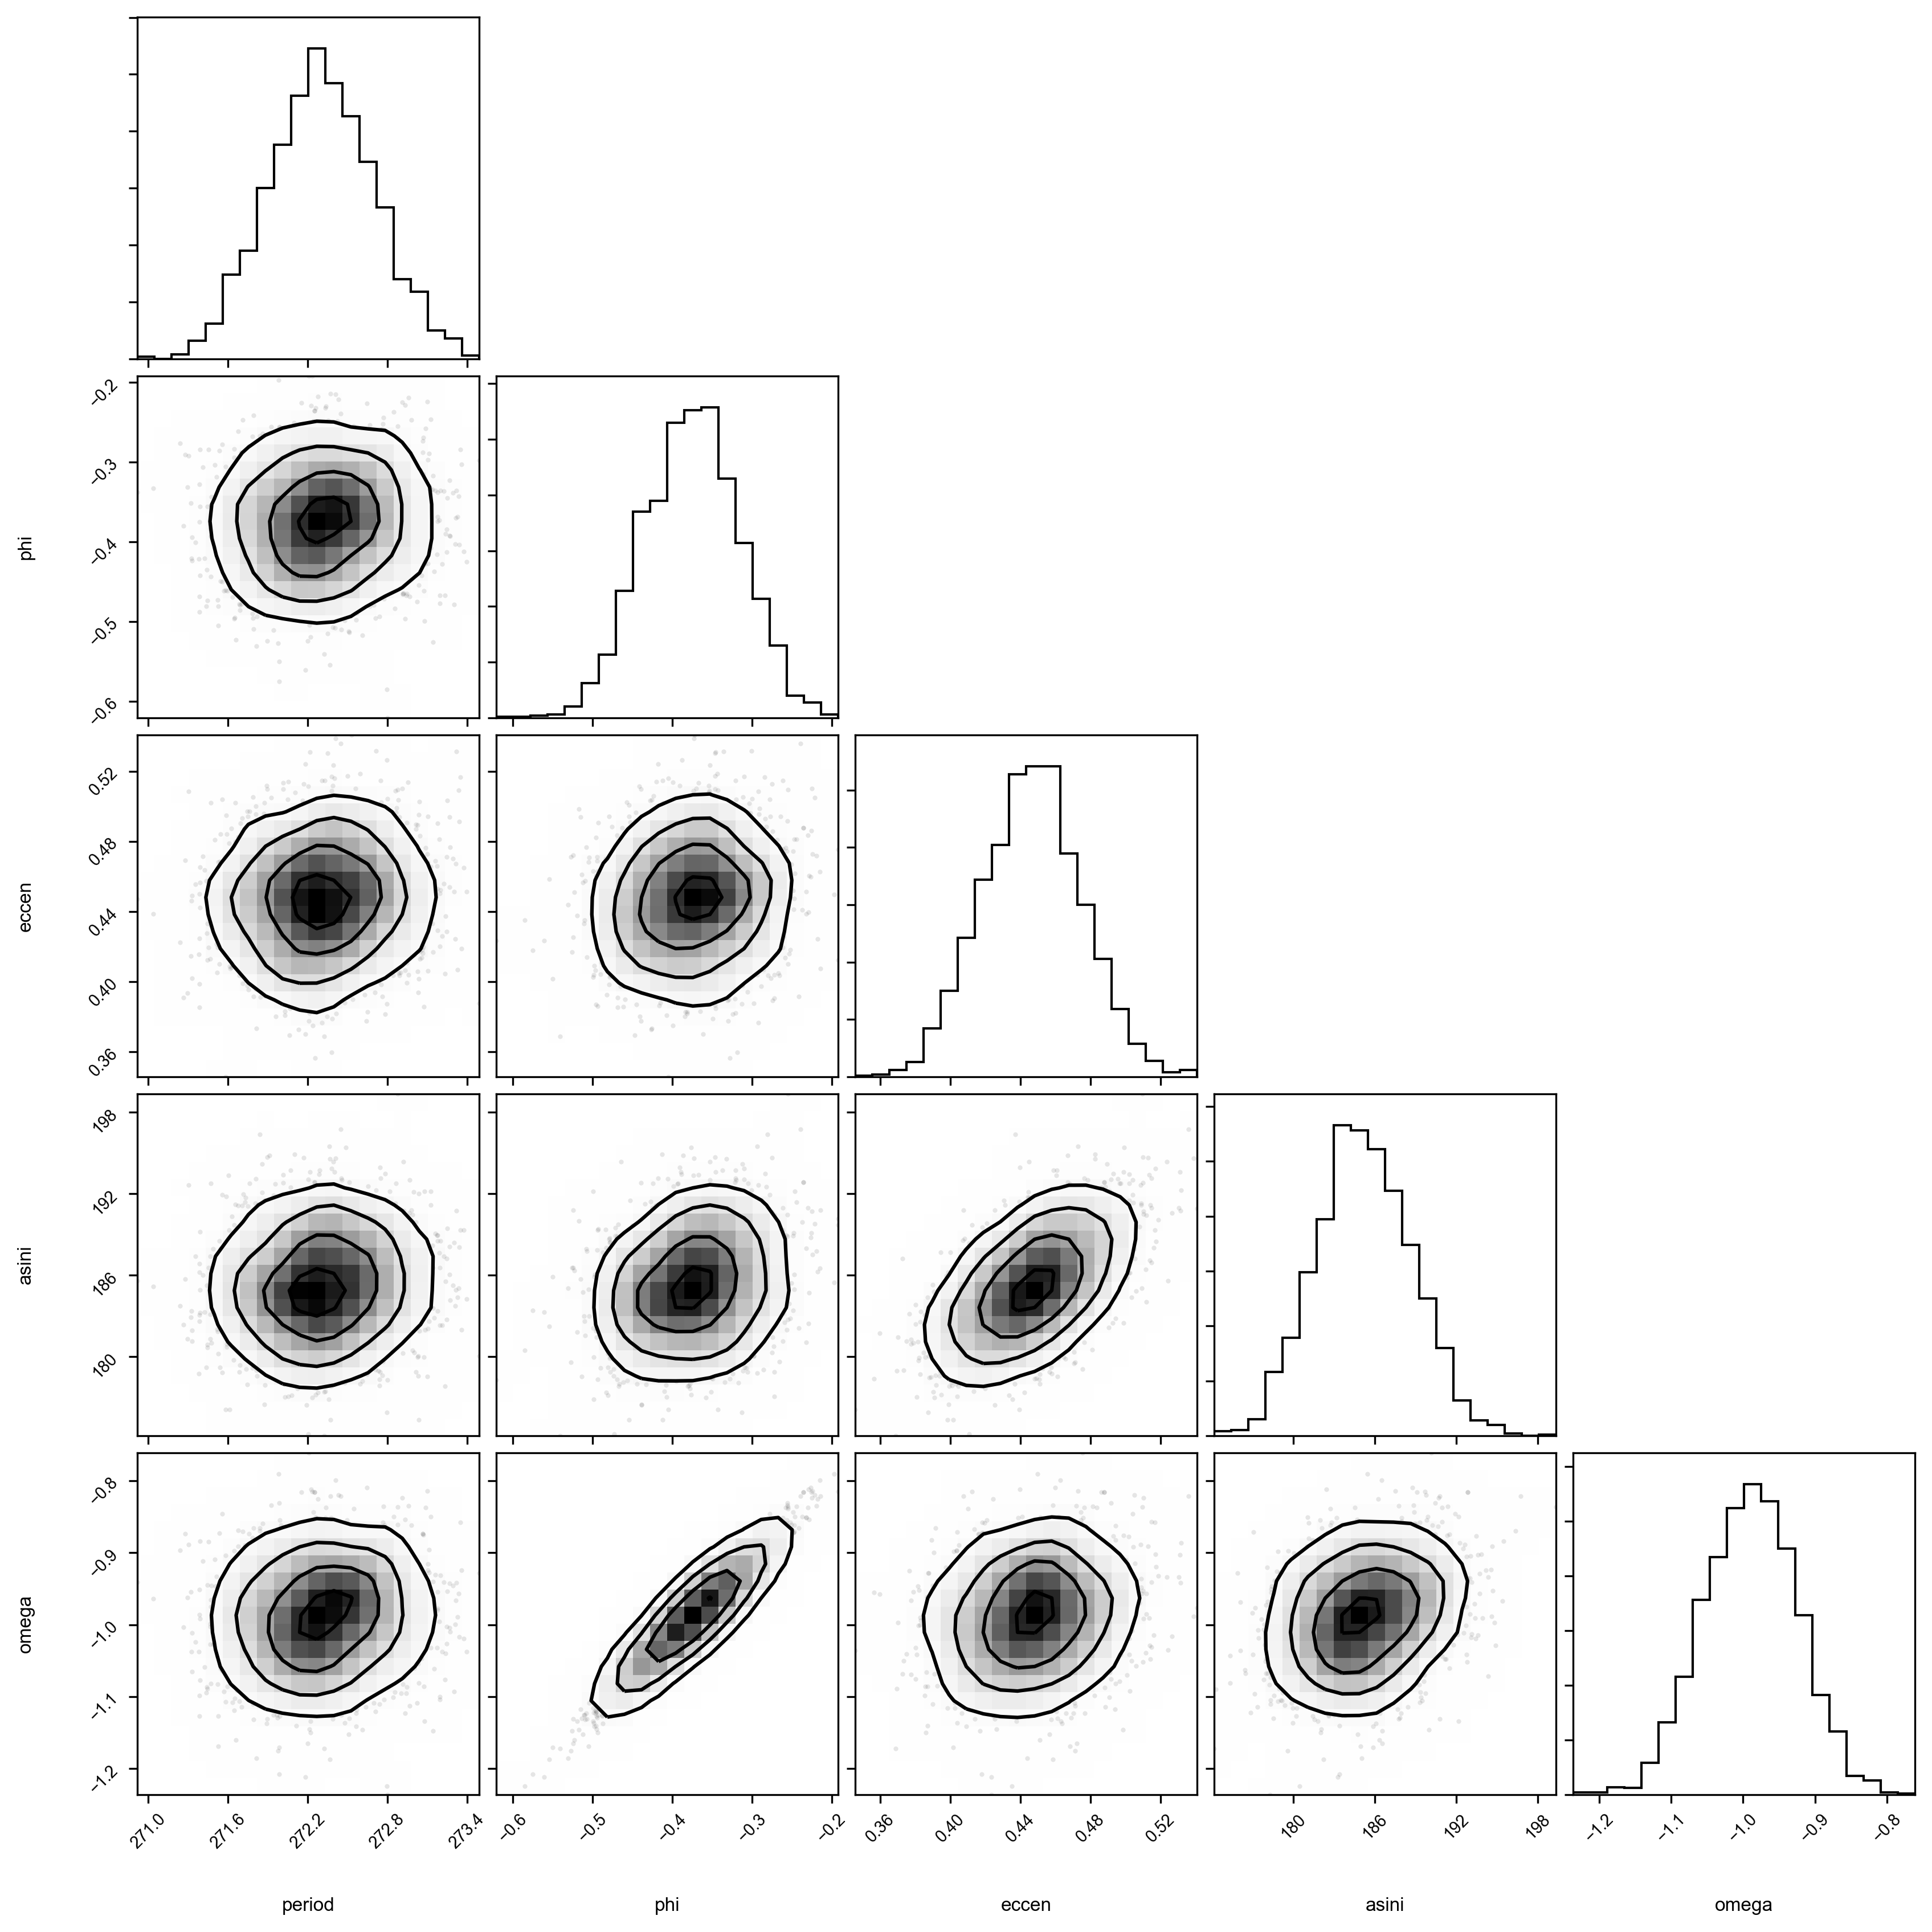

In [40]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=['period', 'phi', 'eccen', 'asini', 'omega']
                                #[v.name for v in model.vars]
                               )
for k in samples.columns:
    if "_" in k:
        samples[k.replace("_", "")] = samples[k]
        del samples[k]
        
corner.corner(samples, smooth=1.);

In [37]:
samples.columns

Index(['logP', 'logasini', 'mean', 'logpower', 'period', 'phi', 'asini',
       'omega', 'eccen', 'logw0', 'logS0', 'logslc', 'lognu0', 'lognu1',
       'lognu2', 'lognu3', 'lognu4', 'nu0', 'nu1', 'nu2', 'nu3', 'nu4',
       'phase0', 'phase1', 'phase2', 'phase3', 'phase4', 'logamp0', 'logamp1',
       'logamp2', 'logamp3', 'logamp4'],
      dtype='object')

# Subdividing model

In [7]:
def dft_phase(x, y, freq):
    freq = np.asarray(freq)
    x = np.array(x)
    y = np.array(y)
    phase = []
    for f in freq:
        expo = 2.0 * np.pi * f * x
        ft_real = np.sum(y * np.cos(expo))
        ft_imag = np.sum(y * np.sin(expo))
        phase.append(np.arctan2(ft_imag,ft_real))
    return phase

In [6]:
from astropy.stats import LombScargle

freq = ms.freq
segment_size=10.

uHz_conv = 1e-6 * 24 * 60 * 60
time_0 = time[0]
time_slice, mag_slice, phase = [], [], []
time_delays, time_midpoints = [], []

# Iterate over lightcurve
for t, y in zip(time, flux):
    time_slice.append(t)
    mag_slice.append(y)

    # In each segment
    if t - time_0 > segment_size:
        # Append the time midpoint
        time_midpoints.append(np.mean(time_slice))

        # And the phases for each frequency
        phase.append(dft_phase(time_slice, mag_slice, freq))
        time_0 = t
        time_slice, mag_slice = [], []

phase = np.array(phase).T
# Phase wrapping patch
for ph, f in zip(phase, freq):
    #mean_phase = np.mean(ph)
    #ph[np.where(ph - mean_phase > np.pi/2)] -= np.pi
    #ph[np.where(ph - mean_phase < -np.pi/2)] += np.pi
    #ph -= np.mean(ph)
    ph = np.unwrap(ph)
    ph -= np.mean(ph)

    td = ph / (2*np.pi*(f / uHz_conv * 1e-6))
    time_delays.append(td)
    
weights = ms.get_weights()


plt.scatter(time_midpoints,np.average(time_delays,axis=0, weights=weights))

td_time, td_td = time_midpoints,np.average(time_delays,axis=0, weights=weights)
nu_arr = freq

td_time, td_td = np.array(td_time), np.array(td_td)


NameError: name 'dft_phase' is not defined

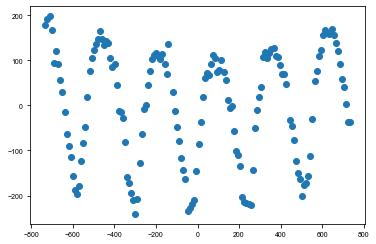

In [12]:
td_time, td_td, td_err = np.loadtxt('paper/data/kic9651065_uncertainties-plus-time-delay_Q99_llc.txt', delimiter=',', usecols=(0,1,2)).T
td_time += 2400000
td_time -= 2454833
td_time -= np.median(td_time)
plt.scatter(td_time, td_td)

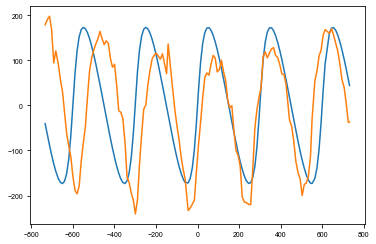

In [13]:
import theano.tensor as tt

with pm.Model() as subdivide_model:
    logP = pm.Normal("logP", mu=np.log(period_guess), sd=1.0, testval=np.log(period_guess))
    period = pm.Deterministic("period", pm.math.exp(logP))
    
    # The time of conjunction
    phi = xo.distributions.Angle("phi")
    logs_lc = pm.Normal('logs_lc', mu=np.log(np.std(flux)), sd=10, testval=0.)
    logasini = pm.Normal('logasini', mu=np.log(a_guess), sd=100, testval=np.log(a_guess))
    asini = pm.Deterministic("asini", tt.exp(logasini))
    drift = pm.Normal('drift', mu=0., sd=0.1, testval=0)
    # Periastron sampled from uniform angle
    omega = xo.distributions.Angle("omega", testval=0.)
    # Eccentricity
    eccen = pm.Uniform("eccen", lower=0, upper=0.9, testval=0.5)
    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=10.0, testval=0.003)
    
    # Mean anom
    M = 2.0 * np.pi * td_time / period - phi
    
    # True anom
    kepler_op = xo.theano_ops.kepler.KeplerOp()
    sinf, cosf = kepler_op(M, eccen + np.zeros(len(td_time)))
    
    factor = 1.0 - tt.square(eccen)
    factor /= 1.0 + eccen * cosf
    psi = factor * (sinf*tt.cos(omega)+cosf*tt.sin(omega))
    tau = asini * psi
    tau += td_time * drift
    taumodel = pm.Deterministic('taumodel', tau - tt.mean(tau))
    
    pm.Normal('obs', mu=taumodel, sd=tt.exp(logs_lc), observed=td_td)
    
    
    plt.plot(td_time, xo.eval_in_model(taumodel))
    plt.plot(td_time, td_td)

optimizing logp for variables: ['mean', 'eccen_interval__', 'omega_angle__', 'drift', 'logasini', 'logs_lc', 'phi_angle__', 'logP']
message: Optimization terminated successfully.
logp: -1163472.9904179932 -> -642.527622892545


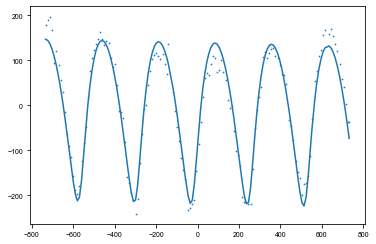

In [14]:
with subdivide_model:
    map_params = xo.optimize()
    
plt.plot(td_time, map_params['taumodel'])
plt.scatter(td_time, td_td, 0.5)

In [15]:
with subdivide_model:
    trace = pm.sample(draws=2000, tune=2000, start=map_params, chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mean, eccen, omega, drift, logasini, logs_lc, phi, logP]
Sampling 2 chains: 100%|██████████| 8000/8000 [01:19<00:00, 53.67draws/s] 


In [16]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logP,5.607149,0.001773,0.000028,5.603677,5.610543,3870.305771,0.999768
logs_lc,3.253943,0.062006,0.001052,3.138179,3.382492,4075.876794,1.000331
logasini,5.218641,0.022943,0.000392,5.174211,5.264496,3249.166911,0.999791
drift,-0.010210,0.005152,0.000078,-0.020323,0.000244,4204.181219,0.999982
mean,-0.138783,9.964726,0.118957,-19.260464,19.109832,4557.084840,0.999780
period,272.367139,0.482792,0.007728,271.422552,273.292637,3870.036203,0.999768
phi,-0.468670,0.071456,0.001207,-0.606235,-0.329502,3836.839606,0.999751
asini,184.731641,4.240644,0.072619,176.657233,193.348929,3239.660106,0.999801
omega,-1.014945,0.079875,0.001332,-1.171833,-0.864711,3753.402486,0.999765
eccen,0.454276,0.035848,0.000616,0.389033,0.526116,3038.637295,1.000888


In [17]:
varnames=['period', 'phi', 'eccen', 'asini', 'omega', 'drift']
rounding = 2
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  272.36  +  0.49  -  0.49
phi :  -0.47  +  0.07  -  0.07
eccen :  0.45  +  0.04  -  0.03
asini :  184.69  +  4.33  -  4.16
omega :  -1.01  +  0.08  -  0.08
drift :  -0.01  +  0.01  -  0.01


In [20]:
0.49 - np.pi

-2.651592653589793

In [23]:
varnames=['period', 'phi', 'eccen', 'asini', 'omega', 'drift']
rounding = 2
for varname in varnames:
    upper, med, lower = np.percentile(trace[varname], [84.13, 50, 15.86])
    print(varname, ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

period :  272.34  +  0.5  -  0.46
phi :  0.12  +  2.09  -  2.37
eccen :  0.45  +  0.04  -  0.04
asini :  184.58  +  4.41  -  4.34
omega :  -1.01  +  0.08  -  0.08
drift :  -0.01  +  0.01  -  0.01


In [18]:
from maelstrom.utils import mass_function
import astropy.units as u
rounding = 3
samples = pm.trace_to_dataframe(trace, varnames=['period', 'asini'])
mfs = mass_function(samples['period'].values * u.day, samples['asini'].values*u.s)
#mfs = np.array(mfs)
upper, med, lower = np.percentile(mfs.value, [84.13, 50, 15.86])
print('mass_func', ': ', np.round(med,rounding), ' + ', np.round(upper - med,rounding), ' - ', np.round(med - lower,rounding))

mass_func :  0.091  +  0.007  -  0.006
